<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#数据来源" data-toc-modified-id="数据来源-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>数据来源</a></span><ul class="toc-item"><li><span><a href="#慧科新闻数据库（2000-2012）" data-toc-modified-id="慧科新闻数据库（2000-2012）-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>慧科新闻数据库（2000-2012）</a></span></li><li><span><a href="#人民日报新闻数据（2018-2023）" data-toc-modified-id="人民日报新闻数据（2018-2023）-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>人民日报新闻数据（2018-2023）</a></span></li></ul></li><li><span><a href="#数据整合" data-toc-modified-id="数据整合-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>数据整合</a></span></li><li><span><a href="#数据预处理" data-toc-modified-id="数据预处理-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>数据预处理</a></span><ul class="toc-item"><li><span><a href="#分词" data-toc-modified-id="分词-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>分词</a></span></li><li><span><a href="#词频统计" data-toc-modified-id="词频统计-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>词频统计</a></span></li><li><span><a href="#关键词提取" data-toc-modified-id="关键词提取-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>关键词提取</a></span></li><li><span><a href="#情感分析" data-toc-modified-id="情感分析-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>情感分析</a></span></li></ul></li><li><span><a href="#数据分析" data-toc-modified-id="数据分析-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>数据分析</a></span><ul class="toc-item"><li><span><a href="#EMV" data-toc-modified-id="EMV-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>EMV</a></span></li></ul></li></ul></div>

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import re
import csv 
import os 

In [3]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

In [29]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

import jieba
import jieba.analyse
from collections import Counter

In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

# 数据来源

## 慧科新闻数据库（2000-2012）

In [5]:
def clean_text(text):
    # 使用正则表达式去除不必要的符号和空格
    cleaned_text = re.sub(r'\u3000|\n|-{3,}', ' ', text)
    text_cleaned = cleaned_text.strip()
    space_patten = re.compile(r'([\u4e00-\u9fa5])\s+([\u4e00-\u9fa5])')
    text_cleaned = space_patten.sub(r'\1\2', text_cleaned)
    text_cleaned = space_patten.sub(r'\1\2', text_cleaned)
    return text_cleaned

def extract_news_info(text):
    # 使用正则表达式提取每条新闻的相关信息
    pattern = r'(\d+)\.\s+(.*?)\s+-\s+\((.*?)\)\s+(\d{4}-\d{2}-\d{2})\s+.*?-{4,}\s+(.*?)文章编号'  # 匹配新闻序号、新闻来源、新闻标题、日期和新闻正文
    matches = re.findall(pattern, text, re.DOTALL)

    news_info = []
    for match in matches:
        news_number = match[0]
        source = match[1].strip()
        title = match[2].strip()
        date = match[3]
        content = match[4].strip()
        
        # 清理新闻内容
        content = clean_text(content)
        
        news_info.append([news_number, source, title, date, content])

    return news_info

In [6]:
def save_to_csv(news_info, filename):
    # 将提取的信息写入CSV文件
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Number', 'Source', 'Title', 'Date', 'Content'])  # 写入表头
        writer.writerows(news_info)

In [7]:
# if __name__ == "__main__":
#     with open('2002-newstext-3.txt', 'r', encoding='utf-8') as file:
#         text = file.read()
#     news_info = extract_news_info(text)
#     save_to_csv(news_info, '2002-news-3.csv')

In [34]:
folder_path = 'huike-newsdata/'
huike_newsdata = []
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
        news_info = extract_news_info(text)
        huike_newsdata.extend(news_info)
save_to_csv(huike_newsdata, 'huike_newsdata.csv')

In [6]:
data = pd.read_csv("huike_newsdata.csv")

In [7]:
data.shape

(33513, 5)

In [8]:
data['Date'] = pd.to_datetime(data['Date'])
data.drop_duplicates(subset = 'Title', keep = 'first', inplace = True)  # 去除标题相同的新闻数据
data = data[['Date', 'Content']]
data.columns = ['date', 'text']

In [9]:
data.head()

,date,text
0,2000-12-31,本报记者王尧走过2000，历经沧桑的香港可以再次骄傲地向世人说，亚洲金融风暴的创痛已成为过去...
1,2000-12-30,今年以来，在我国实施积极财政政策与国际经济趋好的共同促进下，我国宏观经济运行承1999年下半...
2,2000-12-29,在纽约第43号街和百老汇之间的纽约时代广场，醒目地矗立着一座8层楼高，120英尺宽，造价达3...
3,2000-12-29,2000年7月5日，一个平常的日子。但对于历经10年风雨的中国股市来说，却是一个非同寻常的日...
4,2000-12-29,2000年7月5日，一个平常的日子。但对于历经10年风雨的中国股市来说，却是一个非同寻常的日...


In [17]:
selected_data = data[data['text'].str.contains(economic_pattern) & 
                 data['text'].str.contains(uncertainty_pattern) & 
                 data['text'].str.contains(market_pattern)]

In [18]:
selected_data.shape

(16658, 2)

## 人民日报新闻数据（2018-2023）

In [58]:
folder_path = '2018-2023-rmrb-news'
csv_file = '2018-2023-rmrb-news_data.csv'
data = pd.DataFrame(columns=['date', 'text'])

for year_folder in os.listdir(folder_path):
    year_path = os.path.join(folder_path, year_folder)
    if os.path.isdir(year_path):
        year = year_folder.split('年')[0]
        for month_folder in os.listdir(year_path):
            month_path = os.path.join(year_path, month_folder)
            if os.path.isdir(month_path):
                month = month_folder[4:6]
                for day_folder in os.listdir(month_path):
                    day_path = os.path.join(month_path, day_folder)
                    day = day_folder[6:8]
                    with open(day_path, 'r', encoding='utf-8') as file:
                        text = file.read()
                    date = f'{year}-{month}-{day}'
                    data = data.append({'date': date, 'text': text}, ignore_index=True)
data.to_csv(csv_file, index=False)

In [9]:
rmrb_data = pd.read_csv('2018-2023-rmrb-news_data.csv')

In [10]:
rmrb_data.shape

(168156, 2)

In [11]:
rmrb_data['text'] = rmrb_data['text'].str.replace('\n', '')
# rmrb_data['date'] = pd.to_datetime(rmrb_data['date'])

In [12]:
rmrb_data.head()

,date,text
0,2018-10-01,习近平在会见四川航空“中国民航英雄机组”全体成员时强调学习英雄事迹 弘扬英雄精神将非凡英雄精...
1,2018-10-01,烈士纪念日向人民英雄敬献花篮仪式在京隆重举行习近平李克强栗战书汪洋王沪宁赵乐际韩正王岐山出席...
2,2018-10-01,庆祝中华人民共和国成立69周年国务院举行国庆招待会习近平栗战书汪洋王沪宁赵乐际王岐山等出席李...
3,2018-10-01,习近平就印度尼西亚中苏拉威西省地震海啸向印尼总统佐科致慰问电 新华社北京9月30日电 9...
4,2018-10-01,在庆祝中华人民共和国成立六十九周年招待会上的致辞各位来宾、各位朋友、同志们： 今天，我们隆...


# 数据整合

In [13]:
df = pd.concat([data, rmrb_data], axis=0)
df['date'] = pd.to_datetime(df['date'])

In [14]:
df.shape

(198775, 2)

# 数据预处理

## 分词

In [19]:
jieba.load_userdict("user_dict.txt")
stopwords = set()
with open("Chinese_Stop_Word.txt", "r", encoding="utf-8") as f:
    for line in f:
        stopwords.add(line.strip())

In [20]:
len(stopwords)

1210

In [21]:
def process_text(text):
    words = jieba.cut(text)
    words = [word for word in words if word not in stopwords]
    # sentiment_words = jieba.analyse.extract_tags(" ".join(words), topK=10)  # 提取前10个情感词
    return words

In [22]:
selected_data["text_words"] = selected_data["text"].apply(process_text)

In [33]:
selected_data["text_words"] = selected_data["text_words"].apply(lambda x: [word for word in x if re.match(r'^[\u4e00-\u9fa5]+$', word)])

In [34]:
selected_data.head()

,date,text,text_words,month,year
0,2000-12-31,本报记者王尧走过2000，历经沧桑的香港可以再次骄傲地向世人说，亚洲金融风暴的创痛已成为过去...,"[本报记者, 王尧, 走过, 历经沧桑, 香港, 再次, 骄傲地, 世人, 说, 亚洲, 金...",2000-12,2000
1,2000-12-30,今年以来，在我国实施积极财政政策与国际经济趋好的共同促进下，我国宏观经济运行承1999年下半...,"[今年以来, 我国, 实施, 积极财政政策, 国际, 经济, 趋好, 共同, 促进, 下, ...",2000-12,2000
2,2000-12-29,在纽约第43号街和百老汇之间的纽约时代广场，醒目地矗立着一座8层楼高，120英尺宽，造价达3...,"[纽约, 号, 街, 百老汇, 之间, 纽约时代广场, 醒目, 矗立, 一座, 层楼, 高,...",2000-12,2000
3,2000-12-29,2000年7月5日，一个平常的日子。但对于历经10年风雨的中国股市来说，却是一个非同寻常的日...,"[一个, 平常, 日子, 历经, 风雨, 中国股市, 来说, 却是, 一个, 非同寻常, 日...",2000-12,2000
4,2000-12-29,2000年7月5日，一个平常的日子。但对于历经10年风雨的中国股市来说，却是一个非同寻常的日...,"[一个, 平常, 日子, 历经, 风雨, 中国股市, 来说, 却是, 一个, 非同寻常, 日...",2000-12,2000


## 词频统计

In [35]:
monthly_texts = selected_data.groupby(pd.Grouper(key='date', freq='M'))['text_words'].sum()
yearly_texts = selected_data.groupby(pd.Grouper(key='date', freq='Y'))['text_words'].sum()

In [25]:
monthly_top10 = monthly_texts.apply(lambda x: Counter(x)).apply(lambda x: dict(x.most_common(10)))

In [36]:
yearly_top10 = yearly_texts.apply(lambda x: Counter(x)).apply(lambda x: dict(x.most_common(10)))

In [40]:
top_words_df = pd.DataFrame(yearly_top10.tolist(), index=yearly_top10.index)

In [41]:
top_words_df

,企业,经济,发展,市场,公司,我国,中国,投资,一个,美国,银行,问题,改革,建设,工作,国家,新,农村,加强,国际,增长,金融危机,金融
date,,,,,,,,,,,,,,,,,,,,,,,
2000-12-31,2610,2413,2388,1946,1524.0,1442.0,1155,1112.0,1077.0,991.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-12-31,4320,4050,4595,5643,4165.0,2579.0,4366,2652.0,3286.0,2395.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-12-31,4939,4611,4295,5092,4138.0,3034.0,3732,3237.0,2998.0,NaN,2658.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2003-12-31,4438,4405,4435,3588,2687.0,2741.0,2426,2682.0,1950.0,NaN,NaN,2114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-12-31,4751,3630,5906,4421,2735.0,2935.0,3366,2485.0,2615.0,NaN,NaN,2842.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-12-31,5739,5694,10486,4501,NaN,3709.0,5272,NaN,NaN,NaN,NaN,3754.0,4447.0,4187.0,3419.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-31,6661,4613,10479,4451,NaN,3768.0,4547,NaN,NaN,NaN,NaN,NaN,3205.0,5684.0,NaN,3730.0,3261.0,NaN,NaN,NaN,NaN,NaN,NaN
2007-12-31,4115,3437,6518,3139,NaN,2386.0,3882,NaN,NaN,NaN,NaN,2147.0,NaN,3040.0,2207.0,NaN,2320.0,NaN,NaN,NaN,NaN,NaN,NaN
2008-12-31,8566,8709,13033,6340,NaN,4386.0,9793,NaN,NaN,NaN,NaN,NaN,4296.0,5320.0,NaN,NaN,NaN,4502.0,4193.0,NaN,NaN,NaN,NaN


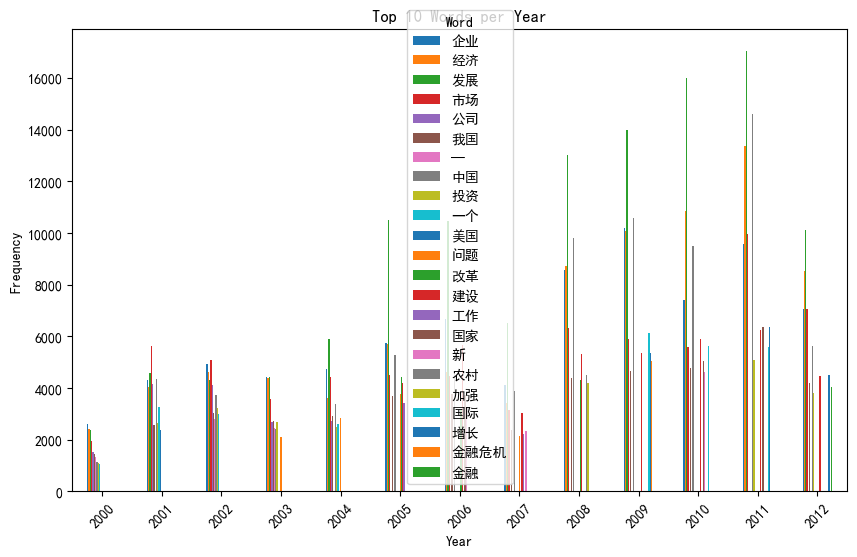

In [46]:
top_words_df.plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Words per Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Word')
plt.show()

## 关键词提取

In [45]:
top_keywords_per_year = {}
for year, texts in yearly_texts.items():
    top_keywords_per_year[year] = jieba.analyse.extract_tags(' '.join(texts), topK=10)

In [46]:
top_keywords_df = pd.DataFrame(top_keywords_per_year)
top_keywords_df = top_keywords_df.T

In [47]:
top_keywords_df

,0,1,2,3,4,5,6,7,8,9
2000-12-31,企业,经济,发展,我国,市场,公司,改革,投资,建设,美国
2001-12-31,市场,企业,发展,公司,经济,中国,我国,资本市场,投资,美国
2002-12-31,企业,市场,经济,发展,我国,资本市场,公司,投资,银行,中国
2003-12-31,企业,发展,经济,我国,市场,投资,改革,公司,建设,资本市场
2004-12-31,发展,企业,市场,我国,资本市场,改革,经济,问题,银行,中国
2005-12-31,发展,改革,企业,建设,经济,我国,加强,中国,市场,问题
2006-12-31,发展,企业,建设,我国,农村,创新,改革,加强,经济,完善
2007-12-31,发展,企业,建设,经济,我国,中国,农村,市场,改革,金融
2008-12-31,发展,企业,经济,中国,农村,建设,改革,加强,我国,市场
2009-12-31,发展,企业,经济,中国,金融危机,国际,建设,我国,增长,大中专


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
yearly_text_list = yearly_texts.apply(lambda x: ' '.join(x))

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(yearly_text_list)

top_keywords_per_year = {}
for i, year in enumerate(yearly_texts.index):
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix[i].toarray().flatten()
    sorted_indices = tfidf_scores.argsort()[::-1][:10]
    top_keywords_per_year[year] = [feature_names[idx] for idx in sorted_indices]

top_keywords_df = pd.DataFrame(top_keywords_per_year)
top_keywords_df = top_keywords_df.T

In [44]:
top_keywords_df

,0,1,2,3,4,5,6,7,8,9
2000-12-31,企业,经济,发展,市场,公司,我国,中国,投资,一个,美国
2001-12-31,市场,发展,中国,企业,公司,经济,一个,投资,我国,美国
2002-12-31,市场,企业,经济,发展,公司,中国,投资,我国,一个,银行
2003-12-31,企业,发展,经济,市场,我国,公司,投资,中国,问题,一个
2004-12-31,发展,企业,市场,经济,中国,我国,问题,公司,一个,投资
2005-12-31,发展,企业,经济,中国,市场,改革,建设,问题,我国,工作
2006-12-31,发展,企业,建设,经济,中国,市场,我国,国家,改革,加强
2007-12-31,发展,企业,中国,经济,市场,建设,我国,工作,问题,一个
2008-12-31,发展,中国,经济,企业,市场,建设,农村,我国,改革,加强
2009-12-31,发展,中国,企业,经济,国际,市场,增长,建设,金融危机,我国


## 情感分析

# 数据分析

## EMV

In [16]:
economic_pattern = '经济|金融|商业'
uncertainty_pattern = '风险|波动|方差|不确定|不明确|波动|震荡|动荡|不稳|未明|不明朗|不清晰|未清晰|难料|难以预料|难以预测|难以预计|难以估计|无法预料|无法预测|无法预计|无法估计|不可预料|不可预测|不可预计|不可估计'
market_pattern = '证券|市场|股市|股票|上证指数|深证指数|中小板|创业板|科创板|资本|原始股|公募|期权|期货|认购|回购|收购|基金|债券|国债|交易|融资|股本'

In [102]:
economic_mask = df['text'].fillna('').str.contains(economic_pattern)
market_mask = df['text'].fillna('').str.contains(market_pattern)
uncertainty_mask = df['text'].fillna('').str.contains(uncertainty_pattern)


print('enconomic新闻条数: ', economic_mask.sum())
print('market新闻条数: ', market_mask.sum())
print('uncertainty新闻条数: ', uncertainty_mask.sum())
print('--------------------')
print('enconomic&market同时出现条数: ', (economic_mask & market_mask).sum())
print('enconomic&market&uncertainty同时出现条数: ', (economic_mask & market_mask & uncertainty_mask).sum())

enconomic新闻条数:  93303
market新闻条数:  74740
uncertainty新闻条数:  43397
--------------------
enconomic&market同时出现条数:  60707
enconomic&market&uncertainty同时出现条数:  28641


In [103]:
selected_df = df[df['text'].str.contains(economic_pattern) & 
                 df['text'].str.contains(uncertainty_pattern) & 
                 df['text'].str.contains(market_pattern)]

In [104]:
selected_df.head()

,date,text
0,2000-12-31,本报记者王尧走过2000，历经沧桑的香港可以再次骄傲地向世人说，亚洲金融风暴的创痛已成为过去...
1,2000-12-30,今年以来，在我国实施积极财政政策与国际经济趋好的共同促进下，我国宏观经济运行承1999年下半...
2,2000-12-29,在纽约第43号街和百老汇之间的纽约时代广场，醒目地矗立着一座8层楼高，120英尺宽，造价达3...
3,2000-12-29,2000年7月5日，一个平常的日子。但对于历经10年风雨的中国股市来说，却是一个非同寻常的日...
4,2000-12-29,2000年7月5日，一个平常的日子。但对于历经10年风雨的中国股市来说，却是一个非同寻常的日...


In [105]:
selected_df.groupby(pd.Grouper(key = 'date', freq = 'M')).describe()

date                                                 \
           count                first freq                 last   
date                                                              
2000-01-31    22  2000-01-03 00:00:00    4  2000-01-31 00:00:00   
2000-02-29    10  2000-02-01 00:00:00    3  2000-02-25 00:00:00   
2000-03-31    45  2000-03-01 00:00:00    9  2000-03-31 00:00:00   
2000-04-30    61  2000-04-03 00:00:00    7  2000-04-29 00:00:00   
2000-05-31    32  2000-05-02 00:00:00    5  2000-05-31 00:00:00   
2000-06-30    23  2000-06-05 00:00:00    6  2000-06-30 00:00:00   
2000-07-31    42  2000-07-01 00:00:00    8  2000-07-31 00:00:00   
2000-08-31     7  2000-08-01 00:00:00    2  2000-08-29 00:00:00   
2000-09-30    33  2000-09-04 00:00:00    4  2000-09-28 00:00:00   
2000-10-31    44  2000-10-07 00:00:00    5  2000-10-31 00:00:00   
2000-11-30    63  2000-11-01 00:00:00    7  2000-11-30 00:00:00   
2000-12-31    67  2000-12-02 00:00:00   10  2000-12-31 00:00:00   
2001-01-31    56  2001-01-02 00:00:00    9  2001-01-22 00:00:00   
2001-02-28    50  2001-02-01 00:00:00    5  2001-02-27 00:00:00   
2001-03-31   116  2001-03-01 00:00:00    8  2001-03-31 00:00:00   
2001-04-30   101  2001-04-02 00:00:00   11  2001-04-30 00:00:00   
2001-05-31   116  2001-05-04 00:00:00   10  2001-05-31 00:00:00   
2001-06-30   103  2001-06-01 00:00:00    9  2001-06-29 00:00:00   
2001-07-31   102  2001-07-01 00:00:00   12  2001-07-31 00:00:00   
2001-08-31    82  2001-08-01 00:00:00    6  2001-08-31 00:00:00   
2001-09-30    68  2001-09-01 00:00:00    9  2001-09-29 00:00:00   
2001-10-31    39  2001-10-08 00:00:00    5  2001-10-31 00:00:00   
2001-11-30    61  2001-11-01 00:00:00    7  2001-11-29 00:00:00   
2001-12-31    80  2001-12-01 00:00:00    9  2001-12-31 00:00:00   
2002-01-31    97  2002-01-01 00:00:00    7  2002-01-31 00:00:00   
2002-02-28    67  2002-02-01 00:00:00    6  2002-02-28 00:00:00   
2002-03-31   103  2002-03-01 00:00:00   10  2002-03-30 00:00:00   
2002-04-30   107  2002-04-01 00:00:00    8  2002-04-30 00:00:00   
2002-05-31    88  2002-05-08 00:00:00    8  2002-05-31 00:00:00   
2002-06-30    94  2002-06-01 00:00:00   10  2002-06-30 00:00:00   
2002-07-31   125  2002-07-01 00:00:00   12  2002-07-31 00:00:00   
2002-08-31   157  2002-08-01 00:00:00   10  2002-08-31 00:00:00   
2002-09-30   101  2002-09-02 00:00:00    8  2002-09-30 00:00:00   
2002-10-31    75  2002-10-08 00:00:00    8  2002-10-31 00:00:00   
2002-11-30    76  2002-11-01 00:00:00    6  2002-11-30 00:00:00   
2002-12-31    92  2002-12-02 00:00:00    8  2002-12-31 00:00:00   
2003-01-31    98  2003-01-01 00:00:00   11  2003-01-31 00:00:00   
2003-02-28    70  2003-02-09 00:00:00    9  2003-02-28 00:00:00   
2003-03-31    74  2003-03-01 00:00:00    8  2003-03-31 00:00:00   
2003-04-30    94  2003-04-01 00:00:00    8  2003-04-29 00:00:00   
2003-05-31    81  2003-05-02 00:00:00    7  2003-05-31 00:00:00   
2003-06-30    80  2003-06-02 00:00:00    8  2003-06-30 00:00:00   
2003-07-31    77  2003-07-01 00:00:00    6  2003-07-31 00:00:00   
2003-08-31    87  2003-08-01 00:00:00    8  2003-08-30 00:00:00   
2003-09-30    79  2003-09-01 00:00:00    7  2003-09-30 00:00:00   
2003-10-31    65  2003-10-01 00:00:00    8  2003-10-31 00:00:00   
2003-11-30    69  2003-11-01 00:00:00    5  2003-11-29 00:00:00   
2003-12-31    96  2003-12-01 00:00:00   10  2003-12-31 00:00:00   
2004-01-31    74  2004-01-01 00:00:00    9  2004-01-31 00:00:00   
2004-02-29   137  2004-02-02 00:00:00   14  2004-02-29 00:00:00   
2004-03-31    92  2004-03-01 00:00:00    8  2004-03-31 00:00:00   
2004-04-30   104  2004-04-01 00:00:00   12  2004-04-30 00:00:00   
2004-05-31    80  2004-05-01 00:00:00   11  2004-05-31 00:00:00   
2004-06-30    92  2004-06-01 00:00:00   11  2004-06-30 00:00:00   
2004-07-31    72  2004-07-01 00:00:00    9  2004-07-29 00:00:00   
2004-08-31    76  2004-08-02 00:00:00    9  2004-08-31 00:00:00   
2004-09-30    81  2004-09-02 00:00:00    9  2004-09-28 00:0

In [114]:
# 按月进行分组
datas = []
for date, df_month in df.groupby(pd.Grouper(key='date', freq='M')):
    d = dict()
    d['date'] = date
    economic_mask = df_month['text'].fillna('').str.contains(economic_pattern)
    market_mask = df_month['text'].fillna('').str.contains(market_pattern)
    uncertainty_mask = df_month['text'].fillna('').str.contains(uncertainty_pattern)
#     print(economic_mask.sum())
#     print(market_mask.sum())
#     print(uncertainty_mask.sum())
    d['epu'] = (economic_mask & market_mask & uncertainty_mask).sum() / economic_mask.sum()
    datas.append(d)
raw_epu_df = pd.DataFrame(datas)

In [113]:
raw_epu_df

,date,epu
0,2000-01-31,0.478261
1,2000-02-29,0.322581
2,2000-03-31,0.483871
3,2000-04-30,0.491935
4,2000-05-31,0.470588
5,2000-06-30,0.489362
6,2000-07-31,0.415842
7,2000-08-31,0.636364
8,2000-09-30,0.366667
9,2000-10-31,0.419048


<AxesSubplot:title={'center':'EMV Index'}, xlabel='date'>

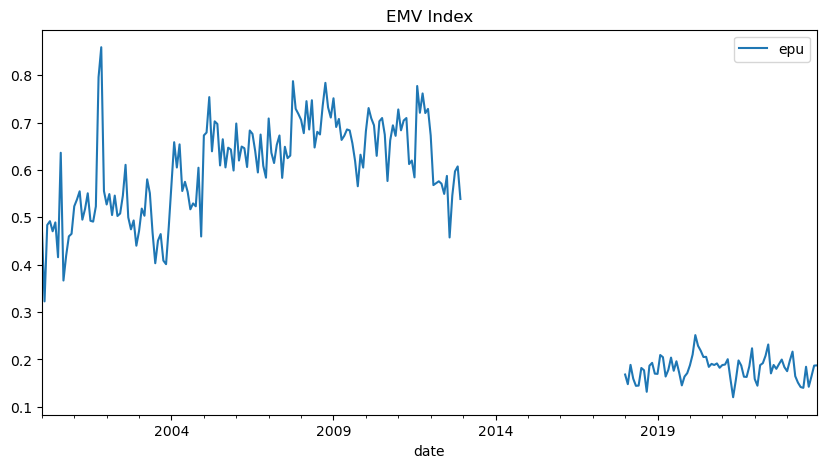

In [115]:
raw_epu_df.set_index('date').plot(figsize=(10, 5), title='EMV Index')